In [2]:
import numpy as np
import pandas as pd
import torch
import random
import re
from sklearn.model_selection import train_test_split 
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import random_split
from sklearn.model_selection import train_test_split
from nltk.tokenize import WordPunctTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import scikitplot as skplt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nlp-txt-classification/sample_submission.csv
/kaggle/input/nlp-txt-classification/train.csv
/kaggle/input/nlp-txt-classification/test.csv


In [3]:
IN_PATH = '/kaggle/input/'
DATA_PATH = IN_PATH+'nlp-txt-classification/'
OUT_PATH = '/kaggle/working/'

In [4]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))
train.shape, test.shape, sample_submission.shape

((41159, 3), (3798, 2), (3798, 2))

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41159 entries, 0 to 41158
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  41158 non-null  object
 1   Text        41158 non-null  object
 2   Sentiment   41155 non-null  object
dtypes: object(3)
memory usage: 964.8+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3798 non-null   object
 1   Text    3798 non-null   object
dtypes: object(2)
memory usage: 59.5+ KB


In [7]:
train.head()

,Unnamed: 0,Text,Sentiment
0,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,1,advice Talk to your neighbours family to excha...,Positive
2,2,Coronavirus Australia: Woolworths to give elde...,Positive
3,3,My food stock is not the only one which is emp...,Positive
4,4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [8]:
sample_submission.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Neutral
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Neutral
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Neutral
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Neutral
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


In [9]:
train.Sentiment.value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [10]:
train.isna().sum()

Unnamed: 0    1
Text          1
Sentiment     4
dtype: int64

In [11]:
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41155 entries, 0 to 41158
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  41155 non-null  object
 1   Text        41155 non-null  object
 2   Sentiment   41155 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [12]:
train.isna().sum()

Unnamed: 0    0
Text          0
Sentiment     0
dtype: int64

<AxesSubplot:xlabel='Sentiment'>

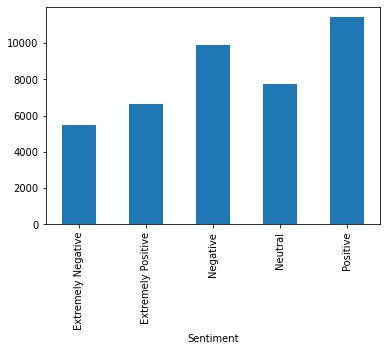

In [13]:
train.groupby(['Sentiment']).size().plot.bar()

In [14]:
def remove_special_characters(text, remove_digits=True):
    text = re.sub('http://\S+|https://\S+|www.\S+', '', text)
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text.strip()

In [15]:
train.Text = train.Text.apply(remove_special_characters)
train.head()

,Unnamed: 0,Text,Sentiment
0,0,MeNyrbie Phil_Gahan Chrisitv and and,Neutral
1,1,advice Talk to your neighbours family to excha...,Positive
2,2,Coronavirus Australia Woolworths to give elder...,Positive
3,3,My food stock is not the only one which is emp...,Positive
4,4,Me ready to go at supermarket during the COVID...,Extremely Negative


In [16]:
test.Text = test.Text.apply(remove_special_characters)
test.head()

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING New Yorkers encounter empty supermark...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldnt find hand sanitizer at Fred Mey...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Panic buying hits NewYork City as anxious shop...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,toiletpaper dunnypaper coronavirus coronavirus...


In [17]:
contraction_dict = {"ain't": "is not",
                    "aren't": "are not",
                    "can't": "cannot",
                    "'cause": "because",
                    "could've": "could have",
                    "couldn't": "could not",
                    "didn't": "did not",
                    "doesn't": "does not",
                    "don't": "do not",
                    "hadn't": "had not",
                    "hasn't": "has not",
                    "haven't": "have not",
                    "he'd": "he would",
                    "he'll": "he will",
                    "he's": "he is",
                    "how'd": "how did",
                    "how'd'y": "how do you",
                    "how'll": "how will",
                    "how's": "how is", 
                    "I'd": "I would",
                    "I'd've": "I would have",
                    "I'll": "I will",
                    "I'll've": "I will have",
                    "I'm": "I am",
                    "I've": "I have",
                    "i'd": "i would",
                    "i'd've": "i would have",
                    "i'll": "i will",
                    "i'll've": "i will have",
                    "i'm": "i am",
                    "i've": "i have",
                    "isn't": "is not",
                    "it'd": "it would",
                    "it'd've": "it would have",
                    "it'll": "it will",
                    "it'll've": "it will have",
                    "it's": "it is",
                    "let's": "let us",
                    "ma'am": "madam",
                    "mayn't": "may not",
                    "might've": "might have",
                    "mightn't": "might not",
                    "mightn't've": "might not have",
                    "must've": "must have",
                    "mustn't": "must not",
                    "mustn't've": "must not have",
                    "needn't": "need not",
                    "needn't've": "need not have",
                    "o'clock": "of the clock",
                    "oughtn't": "ought not",
                    "oughtn't've": "ought not have",
                    "shan't": "shall not",
                    "sha'n't": "shall not",
                    "shan't've": "shall not have",
                    "she'd": "she would",
                    "she'd've": "she would have",
                    "she'll": "she will",
                    "she'll've": "she will have",
                    "she's": "she is",
                    "should've": "should have",
                    "shouldn't": "should not",
                    "shouldn't've": "should not have",
                    "so've": "so have",
                    "so's": "so as",
                    "this's": "this is",
                    "that'd": "that would",
                    "that'd've": "that would have",
                    "that's": "that is",
                    "there'd": "there would",
                    "there'd've": "there would have",
                    "there's": "there is",
                    "here's": "here is",
                    "they'd": "they would",
                    "they'd've": "they would have",
                    "they'll": "they will",
                    "they'll've": "they will have",
                    "they're": "they are",
                    "they've": "they have",
                    "to've": "to have",
                    "wasn't": "was not",
                    "we'd": "we would",
                    "we'd've": "we would have",
                    "we'll": "we will",
                    "we'll've": "we will have",
                    "we're": "we are",
                    "we've": "we have",
                    "weren't": "were not",
                    "what'll": "what will",
                    "what'll've": "what will have",
                    "what're": "what are",
                    "what's": "what is",
                    "what've": "what have",
                    "when's": "when is",
                    "when've": "when have",
                    "where'd": "where did",
                    "where's": "where is",
                    "where've": "where have",
                    "who'll": "who will",
                    "who'll've": "who will have",
                    "who's": "who is",
                    "who've": "who have",
                    "why's": "why is",
                    "why've": "why have",
                    "will've": "will have",
                    "won't": "will not",
                    "won't've": "will not have",
                    "would've": "would have",
                    "wouldn't": "would not",
                    "wouldn't've": "would not have",
                    "y'all": "you all",
                    "y'all'd": "you all would",
                    "y'all'd've": "you all would have",
                    "y'all're": "you all are",
                    "y'all've": "you all have",
                    "you'd": "you would",
                    "you'd've": "you would have",
                    "you'll": "you will",
                    "you'll've": "you will have",
                    "you're": "you are",
                    "you've": "you have"}

In [18]:
def get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [19]:
train.Text = train.Text.apply(lambda x: replace_contractions(x))
test.Text = test.Text.apply(lambda x: replace_contractions(x))

In [22]:
SEED = 42

NUM_CLASSES = 5
MAX_VOCAB_SIZE = 250000
BATCH_SIZE = 64
debug = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
X_train, X_val, y_train, y_val = train_test_split(train.Text, train.Sentiment,
                                                  stratify=train.Sentiment, 
                                                  test_size=0.2,
                                                  random_state=SEED)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((32924,), (8231,), (32924,), (8231,))

In [24]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(list(X_train) + list(X_val) + list(test.Text))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test.Text)

<AxesSubplot:ylabel='Frequency'>

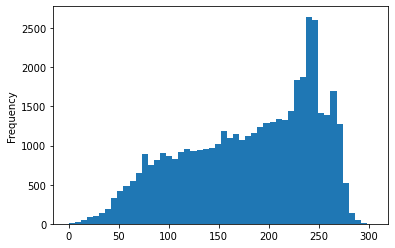

In [26]:
all_texts = pd.concat([train.Text, test.Text], axis=0)
lens = all_texts.apply(lambda s: len(s))
lens.plot.hist(bins=50)

In [27]:
lens.quantile(0.95), max(lens)

(267.0, 304)

In [28]:
MAX_TEXT_LEN = 320

In [29]:
X_train = pad_sequences(X_train, maxlen=MAX_TEXT_LEN)
X_val = pad_sequences(X_val, maxlen=MAX_TEXT_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_TEXT_LEN)

In [30]:
le = LabelEncoder()
y_train = le.fit_transform(y_train.values)
y_val = le.transform(y_val.values)
y_train

array([0, 1, 0, ..., 1, 2, 1])

Glove embeddings

In [31]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip

--2022-07-18 12:10:23--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2022-07-18 12:10:24--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2022-07-18 12:10:24--  https://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/

In [32]:
!unzip glove.840B.300d.zip

Archive:  glove.840B.300d.zip
  inflating: glove.840B.300d.txt     


In [33]:
def load_glove(word_index):
    EMBEDDING_FILE = 'glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(MAX_VOCAB_SIZE, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= MAX_VOCAB_SIZE: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [34]:
if debug:
    embedding_matrix = np.random.randn(MAX_VOCAB_SIZE,300)
else:
    embedding_matrix = load_glove(tokenizer.word_index)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [35]:
max_features, embed_size = embedding_matrix.shape

Стоим модель BiLSTM

In [36]:
class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [37]:
n_epochs = 3 
model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.to(device)

BiLSTM(
  (embedding): Embedding(64607, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=64, out_features=5, bias=True)
)

In [38]:
# Load train and test in CUDA Memory
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.long).to(device)

In [39]:
# Create Torch datasets
train_td = torch.utils.data.TensorDataset(X_train, y_train)
valid_td = torch.utils.data.TensorDataset(X_val, y_val)

In [40]:
# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train_td, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_td, batch_size=BATCH_SIZE, shuffle=False)

In [41]:
train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.to(device)
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(X_val),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * BATCH_SIZE : (i+1) * BATCH_SIZE] = F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(torch.eq(torch.tensor(val_preds.argmax(axis=1)), y_val)) / len(y_val)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/3 	 loss=79.8270 	 val_loss=69.3476  	 val_acc=0.5459  	 time=247.05s
Epoch 2/3 	 loss=62.4527 	 val_loss=58.4343  	 val_acc=0.6369  	 time=245.86s
Epoch 3/3 	 loss=54.7211 	 val_loss=54.2410  	 val_acc=0.6665  	 time=246.68s


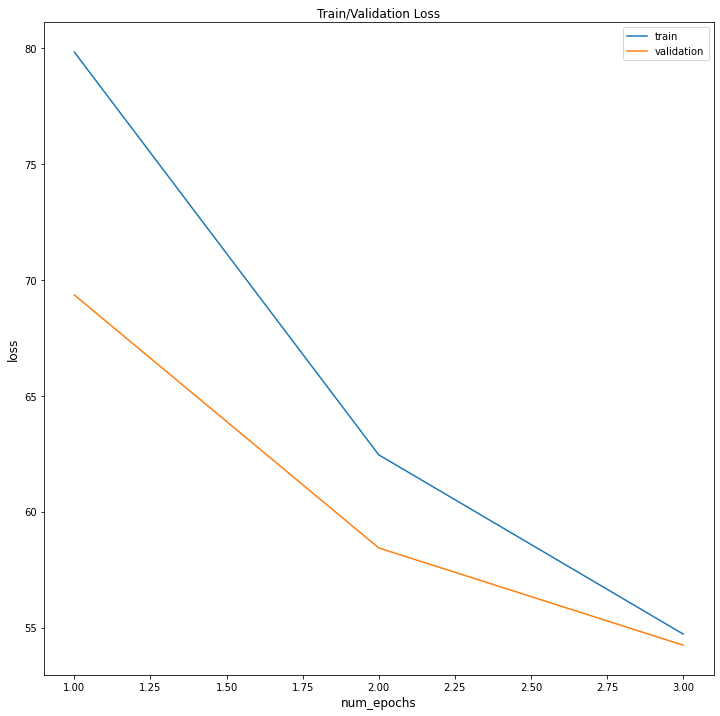

In [42]:
def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    
plot_graph(n_epochs)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

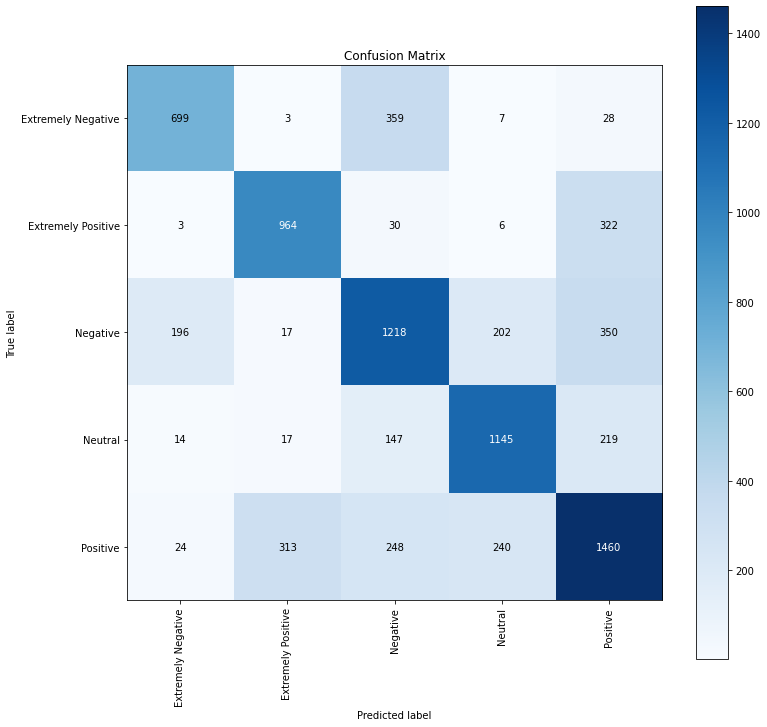

In [43]:
y_true = [le.classes_[x] for x in y_val]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

Submission

In [44]:
pred = model(X_test).detach()
pred = F.softmax(pred).cpu().numpy()
pred = pred.argmax(axis=1)
pred = le.classes_[pred]
sample_submission.Sentiment = pred
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Neutral
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral
